# REDES NUERONALES RECURRENTES

Implementacion con un set de señales trigonometricas.

## Funciones comunes a todas la partes

In [1]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from tqdm import tqdm # para graficar la barra de avance
import wandb # hacer log en whights and bias


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# key de Marcos Uriel Maillot (lelectronfou@gmail.com), cámbiela a su usario una vez finalizada la clase.
wandb.login(key="d63a15806a812590a5525d000eed0e6d6c57a023")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\CIDIEE_NN\.netrc
wandb: Currently logged in as: lelectronfou (mmaillot) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
# Funcion para generar base de datos de señales
def generate_time_series(batch_size, n_steps, n_future):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [5]:
# función que plotea un array de curvas (inputs y outputs)
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  # si tengo profundida de mi serie temporal, me quedo solamente con la 1ra.
  series = series[:,:,0]
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()



In [6]:
# Clase dataset para luego armar los dataloader
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix]) # si no es train, solo devuelve el X


In [7]:
# funciones de entrenamiento
def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")

        bar = tqdm(dataloader['eval'])
        model.eval()

        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")

def predict(model, dataloader, reduced=0):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        primera = 0
        for batch in dataloader:
            X = batch
            X = X[:,-reduced:,:] # el argumento reduced toma las últimas 'reduced' muestras
            if primera == 0:
              print(  'X shape empleado para predecir: ')
              print(X.shape)
              primera = 1
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [8]:
# funciones de entrenamiento
def fit_wandb(model, optimizer, dataloader, patience = 3, patience_factor = 0.001, num_epochs=10, device = device):
    # Initialize Weights & Biases
    wandb.init(project="CEIA-Co18 - RNN-signal", config=model.model_config())

    ## Set device
    model.to(device)

    # definimos función de pérdida
    #optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    # Set metric for callbacks
    best_eval = 100
    pt_epoch = 0

    for epoch in range(num_epochs):
        ### Training Phase ###
        model.train()
        train_loss = []
        eval_loss = []


        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])

        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)


            # forward pass
            y_hat = model(X)
            y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad

            # Compute Loss
            loss = criterion(y_hat, y)

            # Zero gradients, backpropagate, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")



        bar = tqdm(dataloader['eval'])
        model.eval()

        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")

        # Log epoch-level metrics
        wandb.log({
            "epoch": epoch,
            "train_loss": np.mean(train_loss),
            "eval_loss": np.mean(eval_loss),
            "learning_rate": optimizer.param_groups[0]['lr'],
        })

        ## Early stopping
        if np.mean(eval_loss)<=best_eval*(1+patience_factor):
            best_eval = np.mean(eval_loss)
            pt_epoch = 0
        else:
            pt_epoch += 1
            if pt_epoch>=patience:
                print(f"Epoch {epoch+1}/{num_epochs} - Training interrupted due to early stopping condition.")
                wandb.finish()
                break
            else:
                print(f"Epoch {epoch+1}/{num_epochs} - Current epochs without validation metric improvement {pt_epoch}. {patience-pt_epoch} remaining before stopping.")
    # Finish W&B run
    wandb.finish()

def predict(model, dataloader, reduced=0):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        primera = 0
        for batch in dataloader:
            X = batch
            X = X[:,-reduced:,:] # el argumento reduced toma las últimas 'reduced' muestras
            if primera == 0:
              print(  'X shape empleado para predecir: ')
              print(X.shape)
              primera = 1
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [9]:
# función para imprimir parametros del modelo.
def imp_param(model):
  print('-'*84)
  print('PARAMETROS DEL MODELO')
  print('-'*84)
  for name, param in model.named_parameters():
    if param.requires_grad:
      print('Nombre del parámetro: ')
      print(name)
      print('Tamaño del parámetro: ')
      print(param.data.shape)
      print()
  print('-'*84)
  print('NRO TOTAL DE PARAMETROS:')
  t_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(t_params)
  print('-'*84)

## Generación de serie de datos y visualización

In [10]:
n_steps = 50
n_future = 1
series = generate_time_series(10000, n_steps, n_future)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

X and y Train shape
(7000, 50, 1) (7000, 1, 1)
X and y Valid shape
(2000, 50, 1) (2000, 1, 1)
X and y Test shape
(1000, 50, 1) (1000, 1, 1)


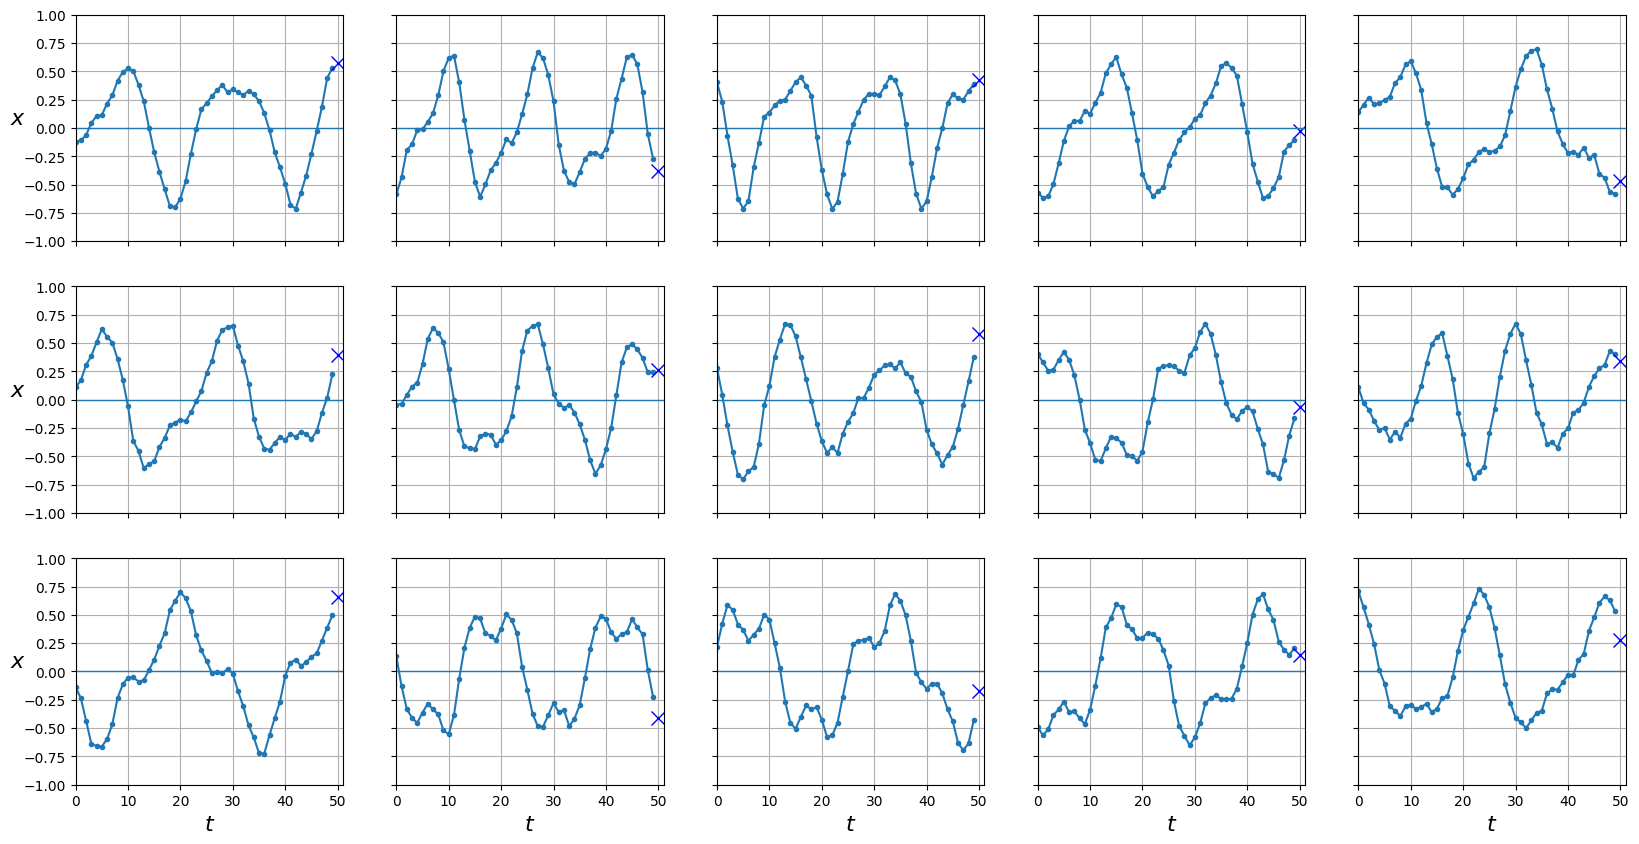

In [11]:
plot_series(X_test, y_test)

In [12]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

## MLP para comparar luego con RNN

In [13]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=n_steps, n_out=n_future):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def model_config(self):
    model_config = {
        "num_layers": 1,
        "num_param": sum(p.numel() for p in self.parameters() if p.requires_grad),
        "num_hidden": 1,
        "architecture": self.__class__.__name__
    }
    return model_config



In [15]:
# n_steps y out_future definidos arriba
mlp = MLP(n_steps, n_future)
print(mlp)

model_config = dict()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
model_config["optimizer"] = optimizer.__class__.__name__
fit_wandb(mlp, optimizer, dataloader)

MLP(
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


epoch numero:  0


valid_loss 0.05352: 100%|██████████| 32/32 [00:00<00:00, 778.24it/s]


epoch numero:  1


valid_loss 0.03296: 100%|██████████| 32/32 [00:00<00:00, 818.05it/s]


epoch numero:  2


valid_loss 0.02486: 100%|██████████| 32/32 [00:00<00:00, 800.48it/s]


epoch numero:  3


valid_loss 0.02002: 100%|██████████| 32/32 [00:00<00:00, 790.39it/s]


epoch numero:  4


valid_loss 0.01722: 100%|██████████| 32/32 [00:00<00:00, 822.97it/s]


epoch numero:  5


valid_loss 0.01529: 100%|██████████| 32/32 [00:00<00:00, 824.63it/s]


epoch numero:  6


valid_loss 0.01381: 100%|██████████| 32/32 [00:00<00:00, 825.87it/s]


epoch numero:  7


valid_loss 0.01269: 100%|██████████| 32/32 [00:00<00:00, 832.91it/s]


epoch numero:  8


valid_loss 0.01157: 100%|██████████| 32/32 [00:00<00:00, 829.09it/s]


epoch numero:  9


valid_loss 0.01068: 100%|██████████| 32/32 [00:00<00:00, 740.98it/s]


epoch,▁▂▃▃▄▅▆▆▇█
eval_loss,█▅▃▃▂▂▂▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▁▁▁▁▁
epoch,9
eval_loss,0.01068
learning_rate,0.001
train_loss,0.01023


X shape empleado para predecir: 
torch.Size([64, 50, 1])
Error cuadratico medio de la estimación final: 
0.009688024


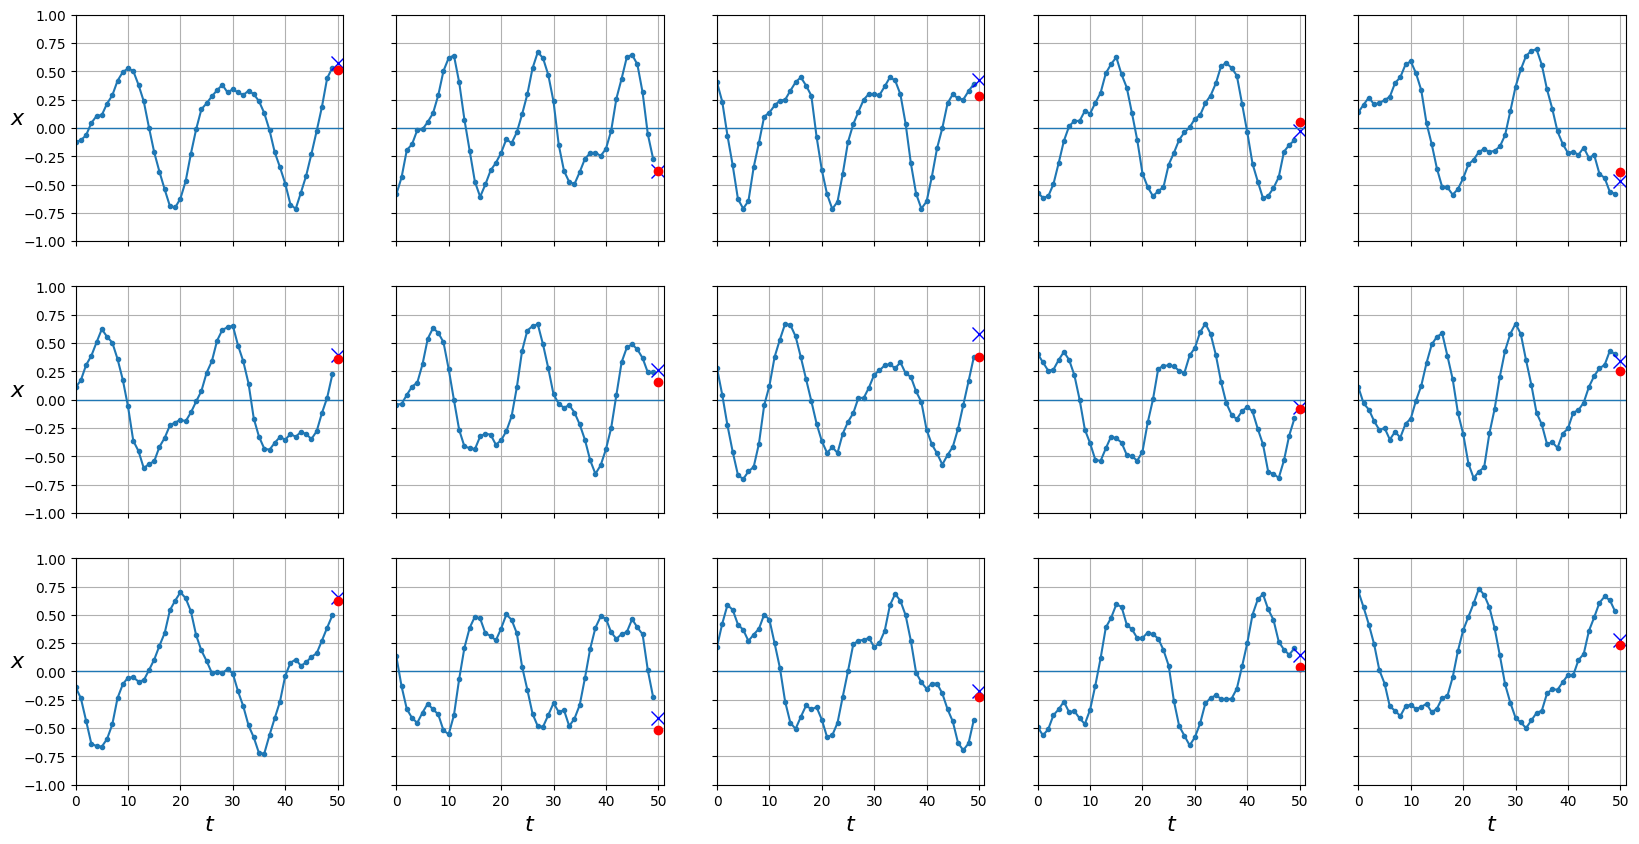

In [17]:
y_pred = predict(mlp, dataloader['test'], reduced=0)
print('Error cuadratico medio de la estimación final: ')
print(mean_squared_error(np.squeeze(y_test), y_pred.cpu()))
plot_series(X_test, y_test, y_pred.cpu().numpy())


## Clase RNN para probar distintas configuraciones.

In [18]:
class RNN(torch.nn.Module):
  def __init__(self, input_size=1, hidden_size=1, num_layers=1, n_out=1):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = torch.nn.Linear(in_features=hidden_size, out_features=n_out)
    # la fc la colocamos para cuando empleemos mas de 1 neurona hidden, ya que
    # tenemos que combinar todas las hidden de la salida de RNN en 1 solo
    # valor a predecir en el futuro. Para eso usaremos las FC.
    # ver en el forward cómo se leen los valores

  def forward(self, x):
    x, h = self.rnn(x)
    # ATENCION!!
    # La salida tentrá una dimensión del [batch x largo de señal x numero de hidden]
    # y a mi FC solo quiero pasarle la última predicción temporal, de todas sus hidden.
    # por eso, me quedo con:
    #       -- todo el batch
    #       -- solo la última predición temporal
    #       -- de todas sus hidden
    x = self.fc(x[:,-1:,:]) # acá le pasamos las últimas hidden a la FC
    y = torch.squeeze(x, 1) # elimino la dimensión sobrante
    return y

  def model_config(self):
    model_config = {
        "num_layers": self.num_layers,
        "num_param": sum(p.numel() for p in self.parameters() if p.requires_grad),
        "num_hidden": self.hidden_size,
        "architecture": self.__class__.__name__
    }
    return model_config



##RNN simple de 1 sola hidden


In [19]:
rnn = RNN(input_size=1, hidden_size=10, num_layers=2)
rnn

RNN(
  (rnn): RNN(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [20]:
# veamos que arroja nuestra rnn

entrada = torch.rand(1, 50, 1)
print('entrada')
print('dimensiones de entrada')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
dimensiones de entrada
[batch, Length, nr_features] 


torch.Size([1, 50, 1])

In [21]:
# paso la entrada a la red
salida = rnn(entrada)

print('salida de la red (largo igual al input):')
print(salida)

print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[0.2682]], grad_fn=<SqueezeBackward1>)
salida shape:
torch.Size([1, 1])


In [22]:
rnn = RNN(input_size=1, hidden_size=10, num_layers=2)
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-3)
model_config["optimizer"] = optimizer.__class__.__name__

fit_wandb(rnn, optimizer, dataloader)

RNN(
  (rnn): RNN(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


epoch numero:  0


valid_loss 0.03216: 100%|██████████| 32/32 [00:00<00:00, 526.02it/s]


epoch numero:  1


valid_loss 0.01669: 100%|██████████| 32/32 [00:00<00:00, 561.34it/s]


epoch numero:  2


valid_loss 0.00974: 100%|██████████| 32/32 [00:00<00:00, 486.81it/s]


epoch numero:  3


valid_loss 0.00716: 100%|██████████| 32/32 [00:00<00:00, 605.30it/s]


epoch numero:  4


valid_loss 0.00616: 100%|██████████| 32/32 [00:00<00:00, 578.91it/s]


epoch numero:  5


valid_loss 0.00557: 100%|██████████| 32/32 [00:00<00:00, 561.03it/s]


epoch numero:  6


valid_loss 0.00518: 100%|██████████| 32/32 [00:00<00:00, 458.53it/s]


epoch numero:  7


valid_loss 0.00469: 100%|██████████| 32/32 [00:00<00:00, 543.87it/s]


epoch numero:  8


valid_loss 0.00435: 100%|██████████| 32/32 [00:00<00:00, 535.20it/s]


epoch numero:  9


valid_loss 0.00411: 100%|██████████| 32/32 [00:00<00:00, 528.62it/s]


epoch,▁▂▃▃▄▅▆▆▇█
eval_loss,█▄▂▂▂▁▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁
epoch,9
eval_loss,0.00411
learning_rate,0.001
train_loss,0.00415


X shape empleado para predecir: 
torch.Size([64, 50, 1])
Error cuadratico medio de la estimación final: 
0.004150956


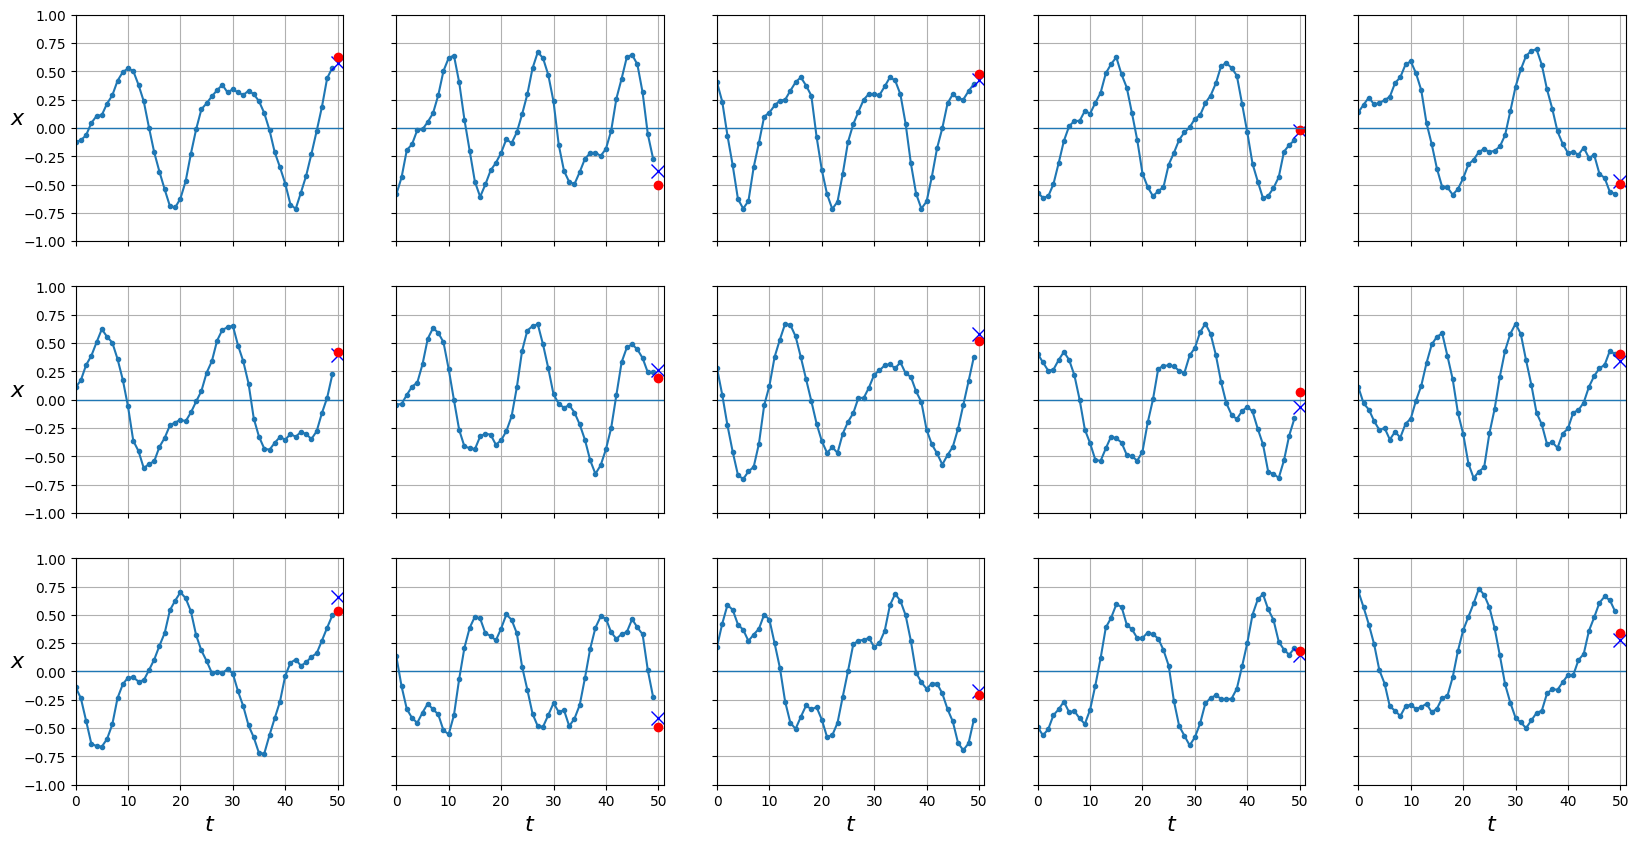

In [24]:
y_pred = predict(rnn, dataloader['test'], reduced=0)
print('Error cuadratico medio de la estimación final: ')
print(mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred.cpu())))

plot_series(X_test, y_test, y_pred.cpu().numpy())



In [26]:
err = []
for k in range(0,n_steps):
  y_pred = predict(rnn, dataloader['test'], reduced=k+1)
  err_k = mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred.cpu()))
  err.append(err_k)




X shape empleado para predecir: 
torch.Size([64, 1, 1])
X shape empleado para predecir: 
torch.Size([64, 2, 1])
X shape empleado para predecir: 
torch.Size([64, 3, 1])
X shape empleado para predecir: 
torch.Size([64, 4, 1])
X shape empleado para predecir: 
torch.Size([64, 5, 1])
X shape empleado para predecir: 
torch.Size([64, 6, 1])
X shape empleado para predecir: 
torch.Size([64, 7, 1])
X shape empleado para predecir: 
torch.Size([64, 8, 1])
X shape empleado para predecir: 
torch.Size([64, 9, 1])
X shape empleado para predecir: 
torch.Size([64, 10, 1])
X shape empleado para predecir: 
torch.Size([64, 11, 1])
X shape empleado para predecir: 
torch.Size([64, 12, 1])
X shape empleado para predecir: 
torch.Size([64, 13, 1])
X shape empleado para predecir: 
torch.Size([64, 14, 1])
X shape empleado para predecir: 
torch.Size([64, 15, 1])
X shape empleado para predecir: 
torch.Size([64, 16, 1])
X shape empleado para predecir: 
torch.Size([64, 17, 1])
X shape empleado para predecir: 
torch.S

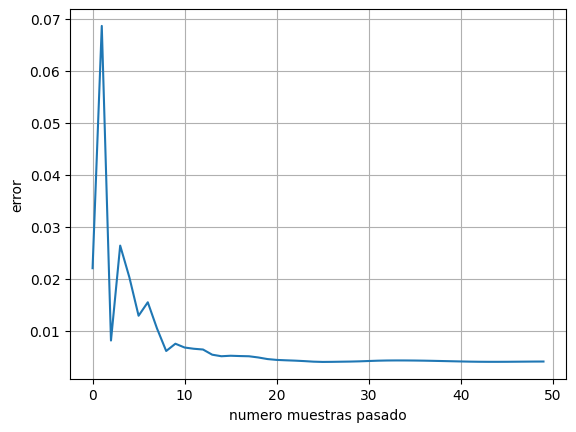

In [27]:
# plot err vs n_steps
plt.plot(range(n_steps), err)
plt.grid(True)
plt.xlabel('numero muestras pasado')
plt.ylabel('error')
plt.show()


### Comparacion de parámetros entre MLP y RNN implementada

In [28]:
# parámetros en el MLP

imp_param(mlp)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 50])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
51
------------------------------------------------------------------------------------


In [29]:
# parámetros en el RNN

imp_param(rnn)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([10, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([10, 10])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([10])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([10])

Nombre del parámetro: 
rnn.weight_ih_l1
Tamaño del parámetro: 
torch.Size([10, 10])

Nombre del parámetro: 
rnn.weight_hh_l1
Tamaño del parámetro: 
torch.Size([10, 10])

Nombre del parámetro: 
rnn.bias_ih_l1
Tamaño del parámetro: 
torch.Size([10])

Nombre del parámetro: 
rnn.bias_hh_l1
Tamaño del parámetro: 
torch.Size([10])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 10])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

-----

##RNN con mas capacidad (más número de neuronas hidden y/o mas capas).

Proponga nuevos modelos con un aumento en el número de neuronas hidden y/ capas y compare los resultados antes encontrados.

Estudie la cantidad de parámetros de estos nuevos modelos con los anteriores.

Estudie cómo se modifica el error de predección sobre el modelo ya entrenado, al modificar el argumento `reduced` de la función `predict`.

In [30]:
rnn_2 = RNN(input_size=1, hidden_size=5, num_layers=1)
rnn_2

RNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [31]:
# parámetros en el RNN

imp_param(rnn_2)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([5, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([5, 5])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([5])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 5])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
46
------------------------------------------------------------------------------------


In [32]:
# veamos que arroja nuestra rnn_2

entrada = torch.rand(1, 20, 1)
print('entrada')

print('dimensiones de entrada')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
dimensiones de entrada
[batch, Length, nr_features] 


torch.Size([1, 20, 1])

In [33]:
# paso la entrada a la red
salida = rnn_2(entrada)

print('salida de la red:')
print(salida)
print('salida shape:')
print(salida.shape)

salida de la red:
tensor([[0.1809]], grad_fn=<SqueezeBackward1>)
salida shape:
torch.Size([1, 1])


In [34]:
fit(rnn_2, dataloader)

epoch numero:  0


valid_loss 0.04062: 100%|██████████| 32/32 [00:00<00:00, 539.12it/s]


epoch numero:  1


valid_loss 0.02301: 100%|██████████| 32/32 [00:00<00:00, 537.66it/s]


epoch numero:  2


valid_loss 0.01448: 100%|██████████| 32/32 [00:00<00:00, 668.43it/s]


epoch numero:  3


valid_loss 0.00981: 100%|██████████| 32/32 [00:00<00:00, 641.69it/s]


epoch numero:  4


valid_loss 0.00776: 100%|██████████| 32/32 [00:00<00:00, 629.06it/s]


epoch numero:  5


valid_loss 0.00685: 100%|██████████| 32/32 [00:00<00:00, 624.51it/s]


epoch numero:  6


valid_loss 0.00648: 100%|██████████| 32/32 [00:00<00:00, 575.46it/s]


epoch numero:  7


valid_loss 0.00615: 100%|██████████| 32/32 [00:00<00:00, 482.56it/s]


epoch numero:  8


valid_loss 0.00594: 100%|██████████| 32/32 [00:00<00:00, 562.64it/s]


epoch numero:  9


valid_loss 0.00571: 100%|██████████| 32/32 [00:00<00:00, 621.55it/s]


epoch numero:  10


valid_loss 0.00557: 100%|██████████| 32/32 [00:00<00:00, 629.13it/s]


X shape empleado para predecir: 
torch.Size([64, 50, 1])


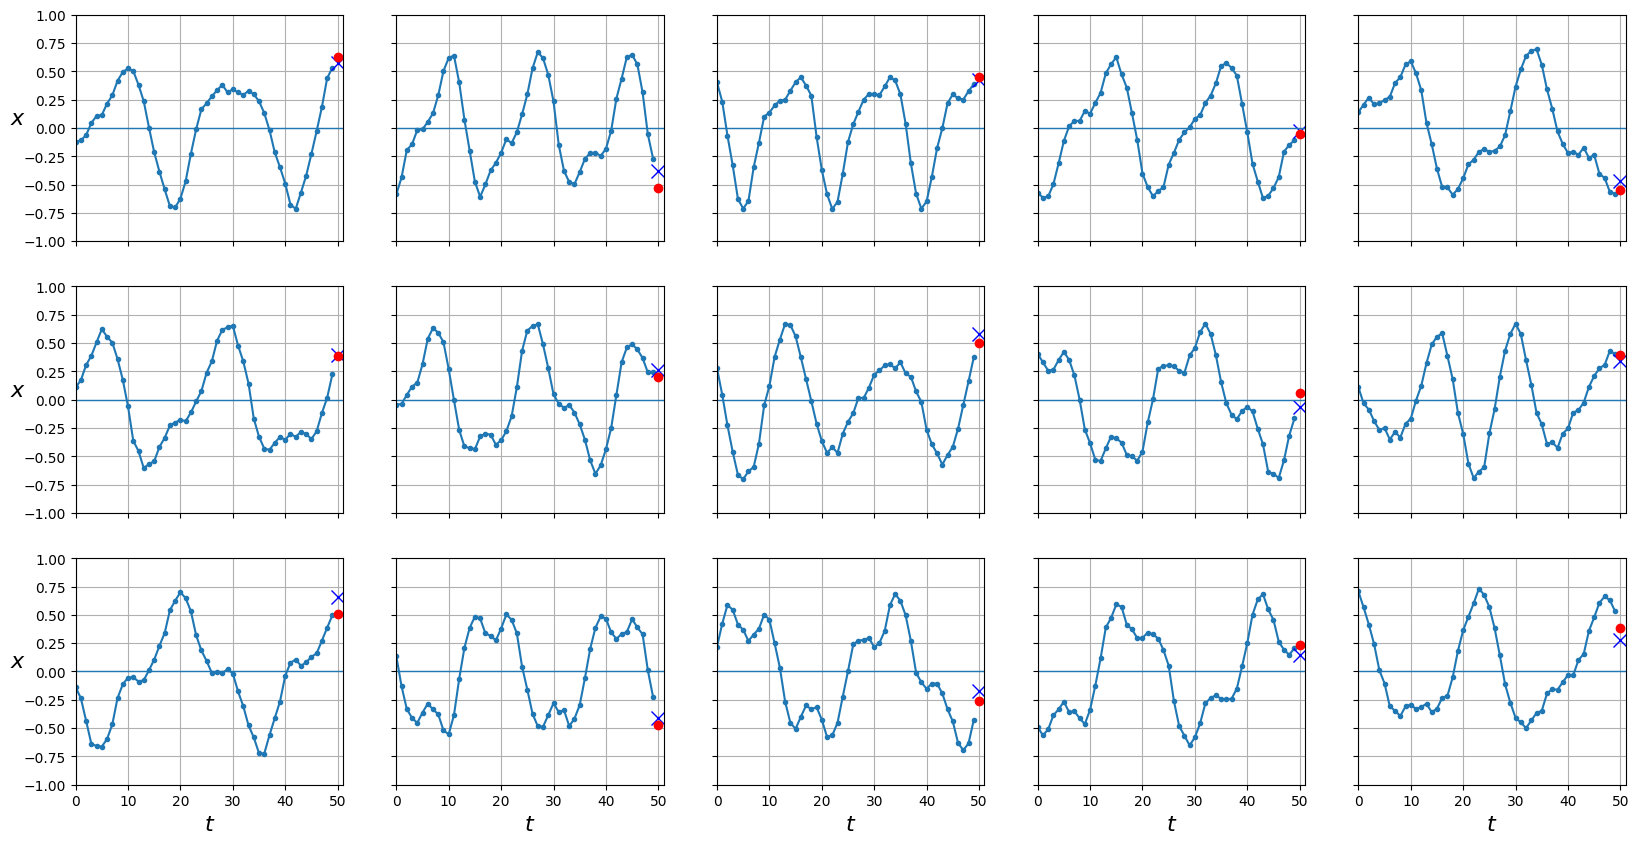

Error cuadratico medio de la estimación final: 


0.005722807

In [35]:
# la probmos con el test
y_pred = predict(rnn_2, dataloader['test'], reduced=0)
plot_series(X_test, y_test, y_pred.cpu().numpy())

print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

## RNN con mas layers

Pruebe entrenar un modelo con más layers.





In [36]:
rnn_deep = RNN(input_size=1, hidden_size=3, num_layers=2)
fit(rnn_deep, dataloader)

epoch numero:  0


valid_loss 0.13653: 100%|██████████| 32/32 [00:00<00:00, 631.83it/s]


epoch numero:  1


valid_loss 0.08950: 100%|██████████| 32/32 [00:00<00:00, 534.83it/s]


epoch numero:  2


valid_loss 0.04558: 100%|██████████| 32/32 [00:00<00:00, 587.27it/s]


epoch numero:  3


valid_loss 0.02389: 100%|██████████| 32/32 [00:00<00:00, 629.13it/s]


epoch numero:  4


valid_loss 0.01176: 100%|██████████| 32/32 [00:00<00:00, 629.13it/s]


epoch numero:  5


valid_loss 0.00666: 100%|██████████| 32/32 [00:00<00:00, 619.11it/s]


epoch numero:  6


valid_loss 0.00580: 100%|██████████| 32/32 [00:00<00:00, 605.39it/s]


epoch numero:  7


valid_loss 0.00567: 100%|██████████| 32/32 [00:00<00:00, 574.07it/s]


epoch numero:  8


valid_loss 0.00550: 100%|██████████| 32/32 [00:00<00:00, 539.50it/s]


epoch numero:  9


valid_loss 0.00544: 100%|██████████| 32/32 [00:00<00:00, 596.42it/s]


epoch numero:  10


valid_loss 0.00535: 100%|██████████| 32/32 [00:00<00:00, 544.06it/s]


X shape empleado para predecir: 
torch.Size([64, 50, 1])
Error cuadratico medio de la estimación final: 
0.005240034


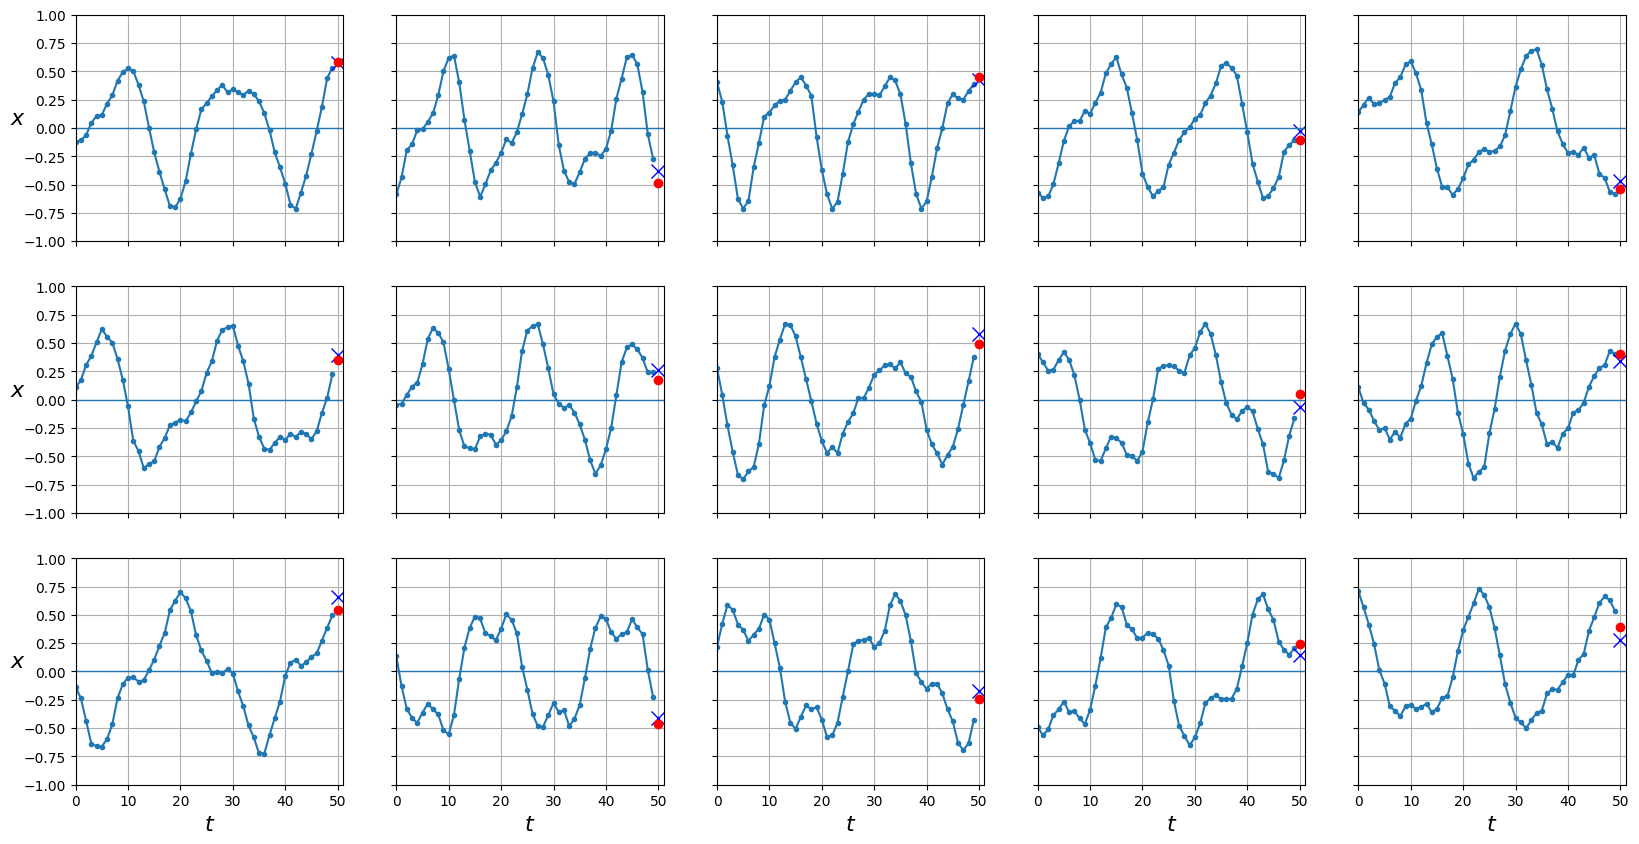

In [38]:
# PROBAR MODIFICAR EL ARGUMENTO REDUCED!!
y_pred = predict(rnn_deep, dataloader['test'], reduced = 0)
print('Error cuadratico medio de la estimación final: ')
print(mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred.cpu())))


plot_series(X_test, y_test, y_pred.cpu().numpy())





In [39]:
# parámetros en el RNN

imp_param(rnn_deep)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([3, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([3, 3])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([3])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([3])

Nombre del parámetro: 
rnn.weight_ih_l1
Tamaño del parámetro: 
torch.Size([3, 3])

Nombre del parámetro: 
rnn.weight_hh_l1
Tamaño del parámetro: 
torch.Size([3, 3])

Nombre del parámetro: 
rnn.bias_ih_l1
Tamaño del parámetro: 
torch.Size([3])

Nombre del parámetro: 
rnn.bias_hh_l1
Tamaño del parámetro: 
torch.Size([3])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 3])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

-----------------

## Input size de 2 dimensiones

Se incorpora la derivada como un feature adicional (le damos más profundidad a la input)

In [40]:
# Funcion para generar base de datos de señales con el feature de derivada
def generate_time_series_derivada(batch_size, n_steps, n_future, derivada=False):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    if derivada:
      fc_ser = series[:,0]
      serie_dev = np.diff(series, axis=1, prepend=fc_ser[:,None])
      series = np.stack([series, serie_dev], axis=-1)
    else:
      series = series[..., np.newaxis]
    return series.astype(np.float32)


In [41]:
# probamos el feature si funciona
serie_derivada = generate_time_series_derivada(100, 50, 1, derivada=True)
print('batch x largo x nro features(si paso mas de 1 feature en cada tiempo)')
serie_derivada.shape

batch x largo x nro features(si paso mas de 1 feature en cada tiempo)


(100, 51, 2)

In [42]:
# para los y deseados, solamente queremos hacer regresión sobre la señal
# (no su derivada). Entonces en y solo sacamos la 1ra muestra de la dimensión
# profundidad

n_steps = 50
n_future = 1
series = generate_time_series_derivada(10000, n_steps, n_future, derivada=True)
X_train_dev, y_train_dev = series[:7000, :n_steps], series[:7000, -n_future:, 0]
X_valid_dev, y_valid_dev = series[7000:9000, :n_steps], series[7000:9000, -n_future:, 0]
X_test_dev, y_test_dev = series[9000:, :n_steps], series[9000:, -n_future:, 0]
print('X and y Train shape')
print(X_train_dev.shape, y_train_dev.shape)

print('X and y Valid shape')
print(X_valid_dev.shape, y_valid_dev.shape)

print('X and y Test shape')
print(X_test_dev.shape, y_test_dev.shape)

X and y Train shape
(7000, 50, 2) (7000, 1)
X and y Valid shape
(2000, 50, 2) (2000, 1)
X and y Test shape
(1000, 50, 2) (1000, 1)


In [43]:
dataset_dev = {
    'train': TimeSeriesDataset(X_train_dev, y_train_dev),
    'eval': TimeSeriesDataset(X_valid_dev, y_valid_dev),
    'test': TimeSeriesDataset(X_test_dev, y_test_dev, train=False)
}

dataloader_dev = {
    'train': DataLoader(dataset_dev['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset_dev['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset_dev['test'], shuffle=False, batch_size=64)
}

### RRN con input_size = 2 para tomar la derivada del input como input

In [44]:
rnn_dev = RNN(input_size=2, hidden_size=3, num_layers=1)
rnn_dev

RNN(
  (rnn): RNN(2, 3, batch_first=True)
  (fc): Linear(in_features=3, out_features=1, bias=True)
)

In [45]:
imp_param(rnn_dev)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([3, 2])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([3, 3])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([3])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([3])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 3])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
25
------------------------------------------------------------------------------------


In [46]:
# veamos que arroja nuestra rnn

entrada = torch.rand(20,2)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([[0.3390, 0.0502],
        [0.2548, 0.5136],
        [0.4907, 0.0559],
        [0.1479, 0.4206],
        [0.2090, 0.8284],
        [0.5036, 0.5034],
        [0.3105, 0.1375],
        [0.1768, 0.5102],
        [0.9176, 0.1921],
        [0.3467, 0.3242],
        [0.4636, 0.0189],
        [0.9802, 0.5397],
        [0.6832, 0.3805],
        [0.8666, 0.3035],
        [0.8061, 0.9844],
        [0.0212, 0.4218],
        [0.1228, 0.7948],
        [0.4253, 0.0242],
        [0.5433, 0.8431],
        [0.8366, 0.6514]])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 20, 2])

In [47]:
# paso la entrada a la red
salida = rnn_dev(entrada)

print('salida de la red (largo igual al input):')
print(salida)

print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[0.2049]], grad_fn=<SqueezeBackward1>)
salida shape:
torch.Size([1, 1])


In [48]:
fit(rnn_dev, dataloader_dev)

epoch numero:  0


valid_loss 0.13198: 100%|██████████| 32/32 [00:00<00:00, 617.03it/s]


epoch numero:  1


valid_loss 0.09362: 100%|██████████| 32/32 [00:00<00:00, 451.68it/s]


epoch numero:  2


valid_loss 0.04459: 100%|██████████| 32/32 [00:00<00:00, 605.39it/s]


epoch numero:  3


valid_loss 0.01761: 100%|██████████| 32/32 [00:00<00:00, 478.91it/s]


epoch numero:  4


valid_loss 0.00918: 100%|██████████| 32/32 [00:00<00:00, 589.34it/s]


epoch numero:  5


valid_loss 0.00709: 100%|██████████| 32/32 [00:00<00:00, 622.40it/s]


epoch numero:  6


valid_loss 0.00620: 100%|██████████| 32/32 [00:00<00:00, 605.06it/s]


epoch numero:  7


valid_loss 0.00579: 100%|██████████| 32/32 [00:00<00:00, 610.37it/s]


epoch numero:  8


valid_loss 0.00556: 100%|██████████| 32/32 [00:00<00:00, 616.69it/s]


epoch numero:  9


valid_loss 0.00543: 100%|██████████| 32/32 [00:00<00:00, 582.62it/s]


epoch numero:  10


valid_loss 0.00526: 100%|██████████| 32/32 [00:00<00:00, 628.80it/s]


X shape empleado para predecir: 
torch.Size([64, 50, 2])
Error cuadratico medio de la estimación final: 
0.004705739


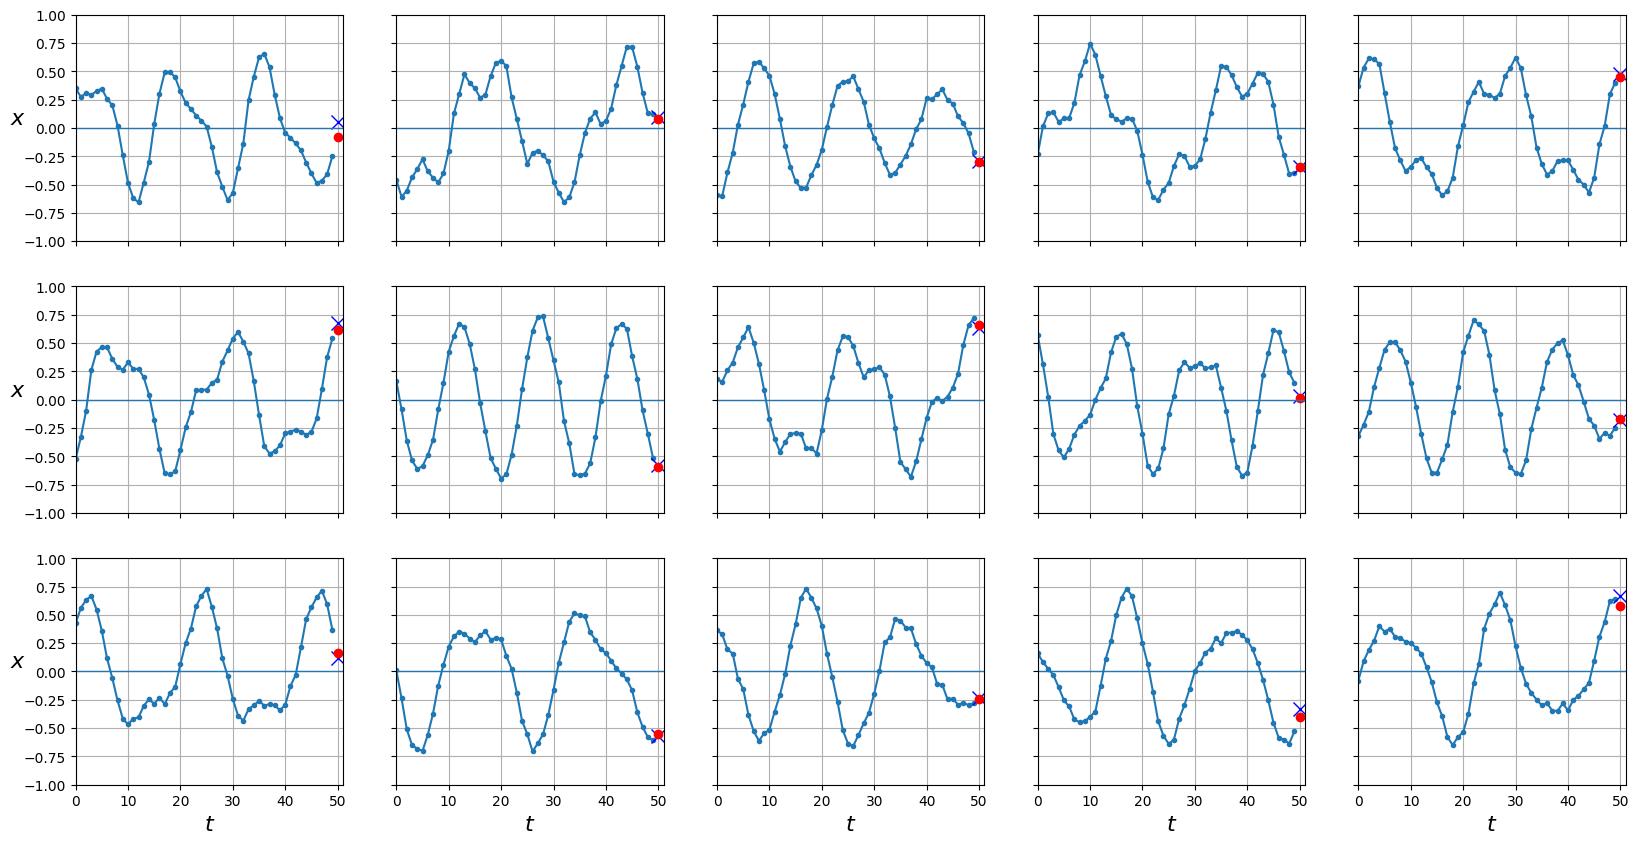

In [50]:
y_pred = predict(rnn_dev, dataloader_dev['test'])
print('Error cuadratico medio de la estimación final: ')
print(mean_squared_error(np.squeeze(y_test_dev), np.squeeze(y_pred.cpu())))

plot_series(X_test_dev, y_test_dev, y_pred.cpu().numpy())



### comparamos la misma arq de red, pero sin el feature "derivada"

Para esto tenemos que armar una nueva arq con input_size = 1 y conservar el resto de hiperparámetros.

In [51]:
rnn_sin_dev = RNN(input_size=1, hidden_size=3, num_layers=1)
rnn_sin_dev

RNN(
  (rnn): RNN(1, 3, batch_first=True)
  (fc): Linear(in_features=3, out_features=1, bias=True)
)

In [52]:
imp_param(rnn_sin_dev)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([3, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([3, 3])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([3])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([3])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 3])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])

------------------------------------------------------------------------------------
NRO TOTAL DE PARAMETROS:
22
------------------------------------------------------------------------------------


In [53]:
fit(rnn_sin_dev, dataloader) # USAR DATALOADER QUE NO TENGA LA DERIVADA (QUE TENGA INPUT SIZE 1)

epoch numero:  0


valid_loss 0.09608: 100%|██████████| 32/32 [00:00<00:00, 475.78it/s]


epoch numero:  1


valid_loss 0.07049: 100%|██████████| 32/32 [00:00<00:00, 565.19it/s]


epoch numero:  2


valid_loss 0.05023: 100%|██████████| 32/32 [00:00<00:00, 517.75it/s]


epoch numero:  3


valid_loss 0.03701: 100%|██████████| 32/32 [00:00<00:00, 633.94it/s]


epoch numero:  4


valid_loss 0.02845: 100%|██████████| 32/32 [00:00<00:00, 628.79it/s]


epoch numero:  5


valid_loss 0.02295: 100%|██████████| 32/32 [00:00<00:00, 612.85it/s]


epoch numero:  6


valid_loss 0.01916: 100%|██████████| 32/32 [00:00<00:00, 629.43it/s]


epoch numero:  7


valid_loss 0.01649: 100%|██████████| 32/32 [00:00<00:00, 621.43it/s]


epoch numero:  8


valid_loss 0.01445: 100%|██████████| 32/32 [00:00<00:00, 577.67it/s]


epoch numero:  9


valid_loss 0.01284: 100%|██████████| 32/32 [00:00<00:00, 490.27it/s]


epoch numero:  10


valid_loss 0.01141: 100%|██████████| 32/32 [00:00<00:00, 578.62it/s]


X shape empleado para predecir: 
torch.Size([64, 50, 1])
Error cuadratico medio de la estimación final: 
0.011220729


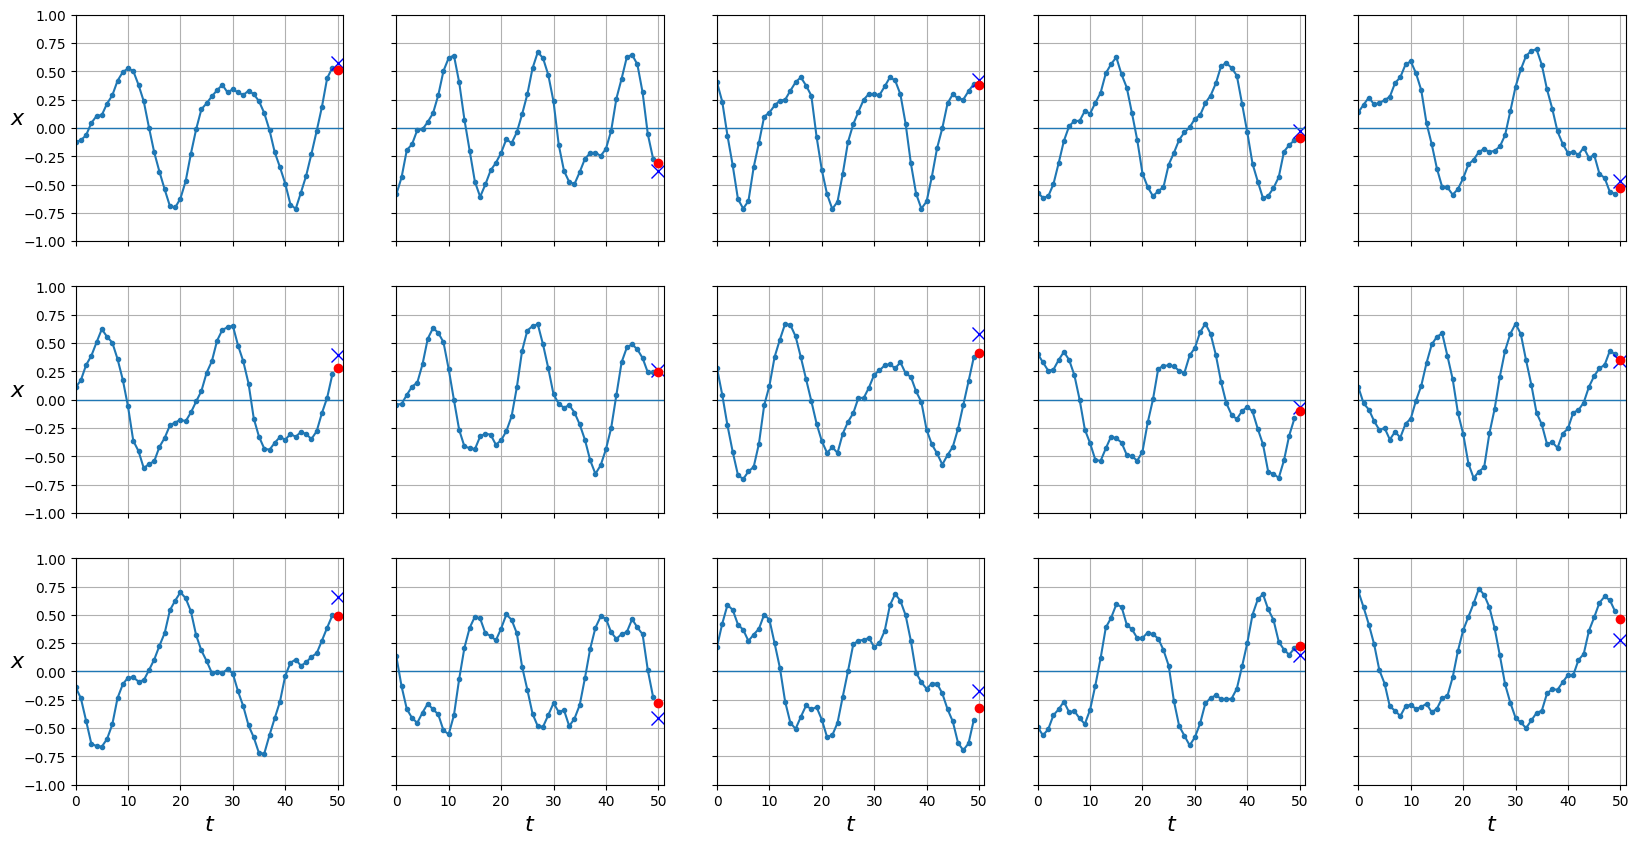

In [55]:
y_pred = predict(rnn_sin_dev, dataloader['test'])
print('Error cuadratico medio de la estimación final: ')
print(mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred.cpu())))

plot_series(X_test, y_test, y_pred.cpu().numpy())

